In [1]:
import sys
import os
import copy

ROOT_DIR = os.getcwd()
sys.path.insert(0, os.path.join(ROOT_DIR, ".."))
sys.path.insert(0, os.path.join(ROOT_DIR, "src"))
sys.path.insert(0, os.path.join(ROOT_DIR, "inerf_utils"))

import json
import torch
import numpy as np
import torchvision.transforms as T
import tqdm
import imageio
import cv2
import matplotlib.pyplot as plt
import wisp
from wisp.core import RenderBuffer, Rays

from scipy.spatial.transform import Rotation as R

In [2]:
import pdb
def bp():
  pdb.set_trace()

In [3]:
# cam_img = cv2.imread("")
# cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)

In [4]:
# plt.imshow(cam_img)

In [5]:
base_scale = 6
base_offset = torch.tensor([0, -0.6, -0.15])
translation_scale = torch.tensor(base_scale/1.25)
translation_offset = translation_scale * base_offset


In [6]:
sys.argv[1:] = [
    '--config=../app/nerf/configs/nerf_hash.yaml',
    '--pretrained=/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_val3_flip_actpose_test4/rob0_cheezit_single_side_env_nobg_sam_iteration_8/model_1/20231117-164216/model.pth',
    '--dataset-path=/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_val3_flip_actpose_test4/merged_images_8',
    '--valid-only'
]

In [7]:
config = {
    'input': '/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_val3_flip_actpose_test/generated_images_formatted_7_nobg_sam/train/rgb_0.png',
    'target': '/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_val3_flip_actpose_test4/inerf_data_iter_9/post_flip_image.png',
    'output': './pose_estimation'
}

In [8]:
W, H = 200, 200

input_image_np = cv2.resize(cv2.imread(config['input'], cv2.IMREAD_UNCHANGED), (W, H), interpolation=cv2.INTER_AREA)
target_image_np = cv2.resize(cv2.imread(config['target'], cv2.IMREAD_UNCHANGED), (W, H), interpolation=cv2.INTER_AREA)

input_image_np = cv2.cvtColor(input_image_np, cv2.COLOR_BGRA2RGBA)
target_image_np = cv2.cvtColor(target_image_np, cv2.COLOR_BGRA2RGBA)

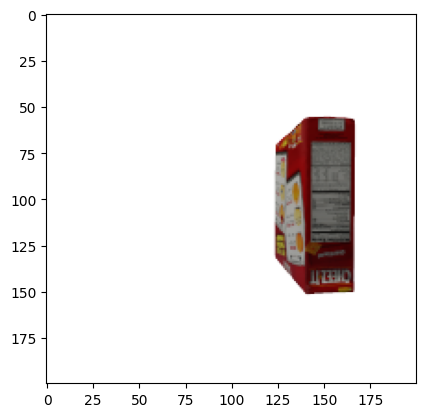

In [9]:
plt.imshow(target_image_np)

In [10]:
fx = (0.5 * H) / np.tan(0.5 * float(1.3213687585295282))
extra_args = {
  'resume' : True,
  'output' : './pose_estimation',
  'device' : 'cuda',
  'z_near' : 0.0,
  'z_far' : 10.0,
  'focal' : fx,
  'lrate' : 1e-3,
}

In [11]:
def convert_to_mat_internal(params) -> torch.Tensor:
    batch_size = params.shape[0]
    a1 = params[:, 0:3]
    a2 = params[:, 3:6]
    translation = params[:, 6:9]

    b1 = torch.nn.functional.normalize(a1, dim=1)
    b1_dot_a2 = torch.bmm(b1.view(-1, 1, 3), a2.view(-1, 3, 1)).view(batch_size, 1)    # Batched dot product
    b2 = torch.nn.functional.normalize(a2 - b1_dot_a2 * b1, dim=1)
    b3 = torch.cross(b1, b2)

    rotation = torch.stack([b1, b2, b3], dim=1)  # Stack row-wise
    extrinsics_mat = torch.cat([rotation, translation.unsqueeze(-1)], dim=2)  # Stack column-wise
    homogeneous_row = translation.new_tensor([[0.0, 0.0, 0.0, 1.0]]).unsqueeze(0).expand(batch_size, 1, 4)
    mat = torch.cat([extrinsics_mat, homogeneous_row], dim=1)
    return mat


In [12]:
from wisp.framework import WispState
from inerf_utils import *
from kaolin.render.camera import Camera, PinholeIntrinsics, CameraExtrinsics, CameraIntrinsics, blender_coords
from kaolin.render.camera.extrinsics_backends import _Matrix6DofRotationRep

from wisp.ops.raygen import generate_pinhole_rays, generate_centered_pixel_coords
from wisp.datasets import SampleRays
from wisp.trainers import MultiviewTrainer
from wisp.models.pipeline import Pipeline

from scipy.optimize import minimize
from scipy.optimize import differential_evolution as de
from scipy.linalg import expm
from scipy.linalg import logm

import plotly.express as px

def make_model(args, args_dict, extra_args, train_dataset, validation_dataset):
    pipeline = torch.load(args.pretrained)
    pipeline.to(extra_args['device'])
    scene_state = WispState()
    trainer = load_trainer(
        pipeline=pipeline,
        train_dataset=train_dataset, 
        validation_dataset=validation_dataset,
        device=extra_args['device'], 
        scene_state=scene_state,
        args=args, 
        args_dict=args_dict
    )
    return trainer, pipeline
    # return pipeline

def gen_camera(pose, focal, w, h, far):
# def gen_camera(params_6d, focal, w, h, far):
    # view_matrix = pose
    # view_matrix = torch.zeros_like(pose)
    # view_matrix[:3, :3] = pose[:3, :3].T
    # view_matrix[:3, -1] = torch.matmul(-view_matrix[:3, :3], pose[:3, -1])
    # view_matrix[3, 3] = 1.0
    view_matrix = torch.linalg.inv(pose)

    x0 = 0.0
    y0 = 0.0

    camera = Camera.from_args(
        view_matrix=view_matrix,
        focal_x=focal,
        focal_y=focal,
        width=w,
        height=h,
        far=far,
        near=0.0,
        x0=x0,
        y0=y0,
        dtype=torch.float32,
        device=extra_args['device']
    )

    # camera_int = PinholeIntrinsics.from_focal(
    #     focal_x=focal,
    #     focal_y=focal,
    #     width=w,
    #     height=h,
    #     far=far,
    #     near=0.0,
    #     x0=x0,
    #     y0=y0,
    #     dtype=torch.float32,
    #     device=extra_args['device']
    # )
    
    # camera_ext = CameraExtrinsics.from_view_matrix(
    #     view_matrix=convert_to_mat_internal(params_6d).squeeze(0),
    #     dtype=torch.float32,
    #     device=extra_args['device'],
    #     backend='matrix_6dof_rotation',
    #     requires_grad=True
    # )
    # camera_ext = CameraExtrinsics(x = torch.tensor([0.1], requires_grad=True))
    
    #     # params=_Matrix6DofRotationRep.convert_from_mat(view_matrix),
    #     params=params_6d,
    #     dtype=torch.float32,
    #     device=extra_args['device'],
    #     requires_grad=True
    # ))
    # camera = Camera(intrinsics=camera_int, extrinsics=camera_ext)

    camera.change_coordinate_system(blender_coords())

    # mask = camera.extrinsics.gradient_mask('t')
    # camera.extrinsics.parameters.register_hook(lambda grad: grad * mask.float())
    
    return camera

def gen_rays_only(camera):
    ray_grid = generate_centered_pixel_coords(camera.width, camera.height, camera.width, camera.height, device=extra_args['device'])
    # bp()
    rays = generate_pinhole_rays(camera, ray_grid).reshape(camera.height, camera.width, 3)
    rays = Rays.stack(rays)
    return rays

# def gen_rays(pose, focal, w, h, far):
#     ray_grid = generate_centered_pixel_coords(camera.width, camera.height, camera.width, camera.height, device=extra_args['device'])
#     rays = generate_pinhole_rays(camera, ray_grid).reshape(camera.height, camera.width, 3)
#     # rays = Rays.stack(rays).to(dtype=torch.float)
    
#     return camera, rays

In [13]:
args, args_dict = parse_args()
train_dataset, validation_dataset = load_dataset(args=args)

['val', 'train', 'transforms_train.json', 'transforms_test.json', 'transforms_val.json']
<class 'wisp.datasets.formats.rtmv_dataset.RTMVDataset'>
False
<class 'wisp.datasets.formats.nerf_standard_dataset.NeRFSyntheticDataset'>
True


loading data: 100%|██████████| 21/21 [00:00<00:00, 61.57it/s]


128.66666666666666


/home/saptarshi/miniconda3/envs/wisp2/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
loading data: 100%|██████████| 64/64 [00:00<00:00, 64.31it/s]


155.46740898662756


In [14]:
args.pretrained

'/home/saptarshi/dev/kaolin-wisp/_results3/ensembles/workdir/cheezit_5_2_val3_flip_actpose_test4/rob0_cheezit_single_side_env_nobg_sam_iteration_8/model_1/20231117-164216/model.pth'

In [15]:
# target_json_path = "/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_val3_flip_actpose_test/merged_images_8_im1/transforms_train.json"

# target_pose = torch.tensor(json.load(open(target_json_path, 'r'))['frames'][-1]['transform_matrix'])
# target_pose[..., :3, 3] *= 6/1.25


In [16]:
import pickle
target_c2w_path = "/home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_val3_flip_actpose_test4/inerf_data_iter_9/post_flip_pre_inerf_c2w.pkl"

# target_pose = torch.tensor(json.load(open(target_json_path, 'r'))['frames'][-1]['transform_matrix'])
target_pose = torch.tensor(pickle.load(open(target_c2w_path, 'rb')))
# target_pose[..., :3, 3] *= 6/1.25

target_pose[..., :3, 3] *= translation_scale.numpy()
target_pose[..., :3, 3] += translation_offset.numpy()


In [17]:
os.makedirs(extra_args['output'], exist_ok=True)

z_near, z_far = extra_args['z_near'], extra_args['z_far']
# in_sz = extra_args['size']

# sz = list(map(int, extra_args['out_size'].split()))
# if len(sz) == 1:
#     H = W = sz[0]
# else:
#     assert len(sz) == 2
#     W, H = sz

model, pipeline = make_model(
    args, args_dict, extra_args, train_dataset, validation_dataset)
# pipeline = make_model(args, args_dict, extra_args, None, None)

# image_to_tensor = get_image_to_tensor_balanced()

# Encoding the input image.
print(f"Input image: {config['input']}")
# input_image = Image.fromarray(input_image_np)
# input_image = T.Resize(in_sz)(input_image)
# input_image = image_to_tensor(input_image).to(device=extra_args['device'])
# input_pose = torch.eye(4)


print(f"Target image: {config['target']}")
# target_image = Image.fromarray(target_image_np)
# target_image = T.Resize(in_sz)(target_image)
target_image_flatten = np.reshape(target_image_np, [-1, 4]) / 255.0
target_image_flatten = torch.from_numpy(
    target_image_flatten).float().to(device=extra_args['device'])


Input image: /home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_val3_flip_actpose_test/generated_images_formatted_7_nobg_sam/train/rgb_0.png
Target image: /home/saptarshi/dev/CustomComposer/workdir/cheezit_5_2_val3_flip_actpose_test4/inerf_data_iter_9/post_flip_image.png


In [18]:
target_pose

tensor([[ 0.0379, -0.0124,  0.9992,  1.4761],
        [-0.9993, -0.0033,  0.0379,  0.4825],
        [ 0.0028, -0.9999, -0.0125,  0.0095],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [19]:
# cam = gen_camera(input_pose.detach(), extra_args['focal'], W, H, z_far)
# cam = gen_camera(target_pose.detach(), extra_args['focal'], W, H, z_far)

# cam = gen_camera(input_pose.detach(), 500, W, H, z_far)
def get_image(cam):
    cam = copy.deepcopy(cam)

    rays = gen_rays_only(cam)
    rays = rays.reshape((rays.shape[0]**2, -1))

    rb = model.renderer.render(pipeline, rays, lod_idx=None)
    rgb = rb.rgb.detach().cpu().numpy().reshape((H, W, 3))
    # alpha = rb.alpha.detach().cpu().numpy().reshape((H, W, 1))
    # v = np.concatenate([rgb, alpha], axis=2)

    # return v
    # return rgb, alpha
    return rgb

In [20]:
def render_pipeline(renderer, pipeline, rays, lod_idx):
    rb = RenderBuffer(xyz=None, hit=None, normal=None, shadow=None, ao=None, dirs=None)
    for ray_pack in rays.split(renderer.render_batch):
        rb  += pipeline.tracer(pipeline.nef, rays=ray_pack, lod_idx=lod_idx, **renderer.kwargs)
    return rb

In [21]:
target_pose[1,3]

tensor(0.4825, dtype=torch.float64)

In [22]:
target_pose[:3,3]

tensor([1.4761, 0.4825, 0.0095], dtype=torch.float64)

In [23]:
# curr_pose = torch.clone(target_pose).detach().unsqueeze(0)
curr_pose = torch.tensor(target_pose)
# curr_pose[1,3] += 1
camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
print(camera.extrinsics.parameters()[0,6:9])

tensor([0.0033, 0.0293, 0.9992], device='cuda:0')


/tmp/ipykernel_181264/702508767.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  curr_pose = torch.tensor(target_pose)


In [24]:
# cam_pose = torch.clone(input_pose.detach())
# cam_pose.requires_grad = True

# Create optimizer.
n_steps = 0

# Pose optimization.
predicted_poses = []
fine_patches = []
gt_patches = []

# x = torch.tensor([0.1], requires_grad=True)
# x = torch.autograd.Variable(torch.tensor(0.1))

curr_pose = torch.tensor(target_pose)
# curr_pose.requires_grad = True

# params = _Matrix6DofRotationRep.convert_from_mat(torch.linalg.inv(torch.clone(target_pose).detach().unsqueeze(0)))
# rep = _Matrix6DofRotationRep(params)

# params = params + x
# params.requires_grad = True
# camera = gen_camera(params, extra_args['focal'], W, H, z_far)

camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
camera.switch_backend('matrix_6dof_rotation')

# camera.rotate(*np.random.uniform(-0.02, 0.02, (3,)).tolist())
# camera.translate(torch.tensor(np.random.uniform(-0.05, 0.05, (3,)), device='cuda', dtype=torch.float32))

# plt.imshow(get_image(camera))
# plt.show()

camera.extrinsics._backend.params[0,6] += 0.2
camera.extrinsics.requires_grad = True

optimizer = torch.optim.Adam(params=[camera.extrinsics.parameters()], lr=0.1)


target_mask = (target_image_flatten[...,3] > 0.001)
# idxs_sampled = torch.where(target_mask)
prev_loss = np.inf

for i_step in range(n_steps):
    optimizer.zero_grad()
    n_samples = 50

    for i in range(n_samples):
        rays = gen_rays_only(camera)
        rays = rays.reshape((rays.shape[0]**2, -1))

        rb = pipeline(rays)
        # rb = render_pipeline(model.renderer, pipeline, rays, None)
        # rb = model.renderer.render(pipeline, rays, lod_idx=None)
        loss = torch.abs(rb.rgb - target_image_flatten[:,:3]).mean()
        loss.backward()

    # print(f"Step {i_step}, loss: {loss}")
        # predicted_poses.append(torch.clone(cam_pose).detach().numpy())
        # fine_patches.append(torch.clone(rgb).detach().cpu().numpy().reshape(H, W, 3))
        # gt_patches.append(torch.clone(target_image_flatten).detach().cpu().numpy().reshape(H, W, 3))
        
    mask = torch.zeros_like(camera.extrinsics.parameters())
    mask[0, 6] = 1
    camera.extrinsics.parameters().grad *= mask
    print(f'{i_step}, loss: {loss.item()}, x : {camera.extrinsics.parameters()[0,6].item()}, grad : {camera.extrinsics.parameters().grad[0,6].item()}')
    # break
    optimizer.step()
    # print(f"Step {i_step}, loss: {loss}, {cam_pose.grad}")

# plt.imshow(get_image(camera))
# plt.show()

/tmp/ipykernel_181264/4290323095.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  curr_pose = torch.tensor(target_pose)


In [25]:
# camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
# camera.switch_backend('matrix_6dof_rotation')
# print(camera.extrinsics.parameters()[0,6])
# camera.extrinsics._backend.params[0,6] += 0.2
# print(camera.extrinsics.parameters())


In [26]:
def get_euler_pose(rot_pose):
  # curr_pose = torch.clone(rot_pose).detach()
  # camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
  best_params_se3 = rot_pose.reshape((4,4)).detach().cpu().numpy()
  best_params_euler = np.concatenate([R.from_matrix(best_params_se3[:3, :3]).as_euler('zxz', degrees=True), best_params_se3[:3, -1]])
  return best_params_euler

def get_rot_pose(euler_pose):
  r = R.from_euler('zxz', euler_pose[:3], degrees=True)
  t = euler_pose[3:]
  pose = np.eye(4)
  pose[:3,:3] = r.as_matrix()
  pose[:3, -1] = t
  return pose

In [27]:
def get_se3_pose(pose_6d):
    a,b,c = pose_6d[3:]
    skm = np.array([[0,a,b], [-a,0,c], [-b,-c,0]])
    rot = expm(skm)
    se3_pose = np.eye(4)
    se3_pose[:3,:3] = rot
    se3_pose[:3,-1] = pose_6d[:3]
    return se3_pose

def get_pose_6d(se3_pose):
    rot = se3_pose[:3,:3]
    skm = logm(rot)
    pose_6d = np.zeros(6)
    pose_6d[:3] = se3_pose[:3,-1]
    pose_6d[3:] = np.array((skm[0,1], skm[0,2], skm[1,2]))
    return pose_6d

In [28]:
# v = torch.random.get_rng_state()

def lossfn2(p, get_grad=False, rewrite=False, opt_all=False, resample=False):
    curr_pose = torch.tensor(target_pose).detach()
    camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
    # bp()
    # print(camera.extrinsics._backend.params)
    # print(p)
    camera.extrinsics._backend.params = torch.tensor(p, device='cuda', dtype=torch.float32)
    camera.switch_backend('matrix_6dof_rotation')
    # print(type(x))
    # print(camera.extrinsics._backend.params[0,6:])
    # if opt_all:
    #     camera.extrinsics._backend.params = torch.tensor(p, device='cuda')
    # elif rewrite:
    #     camera.extrinsics._backend.params[0,6:] = torch.tensor(p, device='cuda')
    # else:
    #     camera.extrinsics._backend.params[0,6:] += torch.tensor(p, device='cuda')
    
    # print(camera.extrinsics.parameters().dtype)
    # print(camera.intrinsics.parameters().dtype)

    if get_grad:
        camera.extrinsics.requires_grad = True

    # camera.extrinsics._backend.params[0,6:] = torch.tensor(p, device='cuda')
    # camera.extrinsics._backend.params[0] = torch.tensor(p, device='cuda')

    # camera.extrinsics._backend.params[0] = torch.tensor(p, device='cuda')

    # camera.extrinsics._backend.params[0,6:] += torch.tensor((x,y,z), device='cuda')
    # camera.extrinsics._backend.params[0,6:] = torch.tensor((x,y,z), device='cuda')

    if resample:
        total_loss = 0
        num_samples = 50
        for i in range(num_samples):
            rays = gen_rays_only(camera)
            rays = rays.reshape((rays.shape[0]**2, -1))
            rb = pipeline(rays)
            loss = torch.square(rb.rgb - target_image_flatten[:,:3]).mean()
            total_loss += loss
            if get_grad:
                loss.backward()
        loss = total_loss / num_samples
    else:
        rays = gen_rays_only(camera)
        rays = rays.reshape((rays.shape[0]**2, -1))
        # torch.random.set_rng_state(v)
        rb = pipeline(rays)
        loss = torch.abs(rb.rgb - target_image_flatten[:,:3]).mean()
        if get_grad:
            loss.backward()

    # plt.imshow(rb.rgb.reshape((200,200,3)).detach().cpu().numpy())
    # plt.show()
    # print(loss)
    # print(camera.extrinsics._backend.params.grad)
    if get_grad:
        return loss.item(), camera.extrinsics._backend.params.grad[0, 6].detach().cpu().numpy()
    return loss.item()

    # print(loss)
    # mask = torch.zeros_like(camera.extrinsics.parameters())
    # mask[0,7] = 1
    # camera.extrinsics.parameters().grad *= mask

def cvt_pose(pose):
    curr_pose = torch.clone(pose).detach()
    camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
    # bp()
    # camera.switch_backend('matrix_6dof_rotation')
    return camera.extrinsics._backend.params

def cvt_pose_se3(pose):
    pose = torch.clone(pose).detach()
    camera = gen_camera(pose, extra_args['focal'], W, H, z_far)
    pose = camera.extrinsics._backend.params.cpu().numpy().reshape((4,4))
    return pose

def get_scipy_image(t):
    camera = gen_camera(curr_pose, extra_args['focal'], W, H, z_far)
    # camera.switch_backend('matrix_6dof_rotation')
    camera.extrinsics._backend.params = torch.tensor(t, device='cuda', dtype=torch.float32)
    print(camera.extrinsics.parameters().dtype, camera.intrinsics.parameters().dtype)
    im = get_image(camera)
    return (255*im).astype(np.uint8) 

def grad(x,y,z):
    h = 1e-4
    gx = (lossfn2((x+h, y, z)) - lossfn2((x,y,z))) / h
    return gx

def lossfn_scipy(p):
    return lossfn2(p, rewrite=True)

def lossfn_euler(p):
    pose = get_rot_pose(p)
    return lossfn2(pose.flatten())

def lossfn_combined_scipy(p):
    se3_pose = get_se3_pose(p)
    return lossfn2(se3_pose, rewrite=True, opt_all=True)

In [29]:
converted_pose = cvt_pose(target_pose)[0, 6:].detach().cpu().numpy()
converted_pose

array([ 3.2839454e-03,  2.9338583e-02,  9.9920326e-01, -1.2492531e-02,
       -3.7904933e-02, -1.4931221e+00, -7.5739284e-17,  8.0120657e-19,
        5.2134532e-19,  1.0000000e+00], dtype=float32)

In [30]:
pose_se3 = get_pose_6d(target_pose)
# new_pose_6d = best_pose_6d.copy()
# best_pose_6d = get_pose_6d(pose)
# new_pose_6d += np.random.normal(np.zeros(6), scale=0.1)
# new_pose_6d[3:] += np.random.normal(np.zeros(3), scale=0.5)
# new_pose_6d[:3] += np.random.normal(np.zeros(3), scale=0.1)

In [31]:
original_pose = torch.tensor(
  [[0.  , 0.  ,1.  , 0.3 ],
  [1.  , 0.  , 0.  , 0.5 ],
  [0.  , 1.  , 0.  , 0.15],
  [0.  , 0.  , 0.  , 1.  ]])

In [32]:
# original_pose[:3,-1] *= 6/1.25     
original_pose[..., :3, 3] *= translation_scale.numpy()
original_pose[..., :3, 3] += translation_offset.numpy()


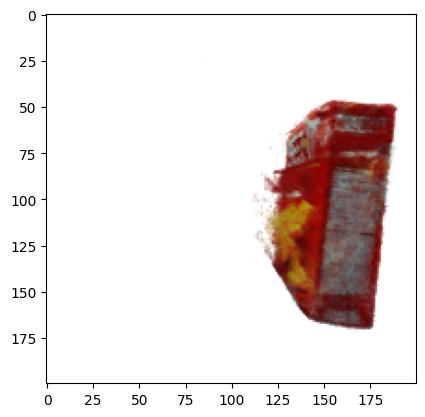

In [33]:
plt.imshow(get_image(gen_camera(original_pose, extra_args['focal'], W, H, z_far)))


tensor([[-0.4642, -0.4941,  0.7351,  0.6645],
        [-0.8847,  0.2191, -0.4114,  0.7351],
        [ 0.0422, -0.8413, -0.5388, -0.7583],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

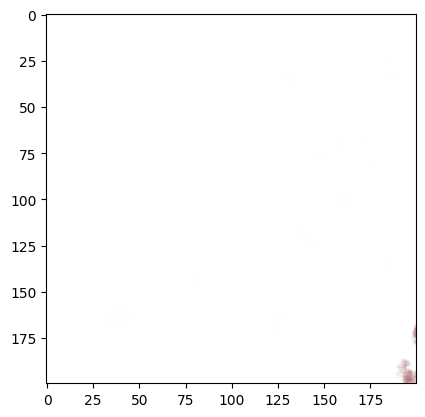

In [68]:
pose2 = torch.clone(target_pose.detach())
pose2[:3,-1] += pose2[:3,2]
pose2[2,-1] -= 2

pose2 = torch.tensor([
  [-0.4642, -0.4941,  0.7351,  0.6645],
  [-0.8847,  0.2191, -0.4114,  0.7351],
  [ 0.0422, -0.8413, -0.5388, -0.7583],
  [ 0.0000,  0.0000,  0.0000,  1.0000]
])

plt.imshow(get_image(gen_camera(pose2, extra_args['focal'], W, H, z_far)))
pose2

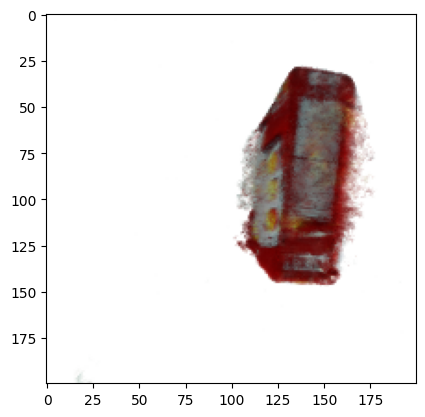

In [34]:
plt.imshow(get_image(gen_camera(target_pose, extra_args['focal'], W, H, z_far)))

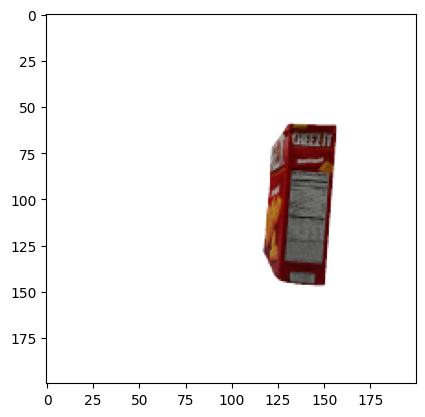

In [36]:
plt.imshow(target_image_np)

In [37]:
pose = cvt_pose_se3(target_pose)
best_pose_6d = get_pose_6d(pose)
new_pose_6d = best_pose_6d.copy()

logm result may be inaccurate, approximate err = 8.648438330464761e-07


/tmp/ipykernel_3047823/3397254522.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  pose_6d[3:] = np.array((skm[0,1], skm[0,2], skm[1,2]))


In [38]:
lossfn_combined_scipy(pose_se3)

/tmp/ipykernel_3047823/2793958132.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  curr_pose = torch.tensor(target_pose).detach()


0.05209280550479889

In [39]:
print(new_pose_6d.shape)
print(pose_se3.shape)

(6,)
(6,)


/tmp/ipykernel_3047823/2793958132.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  curr_pose = torch.tensor(target_pose).detach()


Loss at initial point 0.06267715245485306
iter 0, loss 0.022620460018515587
torch.float32 torch.float32
torch.float32 torch.float32


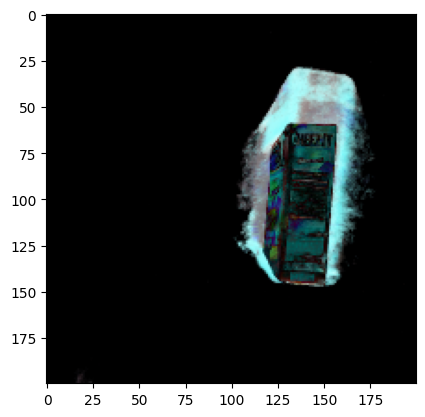

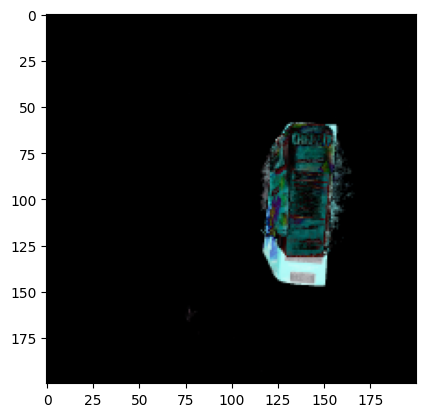

In [40]:
tol = 1e-4
iter = 0
x0 = new_pose_6d
prev_loss = np.inf
print(f'Loss at initial point {lossfn_combined_scipy(new_pose_6d)}')
while True:
    val = minimize(
        fun = lossfn_combined_scipy,
        x0 = x0,
        method='Nelder-Mead', 
    )
    print(f'iter {iter}, loss {val.fun}')
    if iter > 5 and (abs(prev_loss - val.fun) < tol):
        break
    x0 = val.x
    prev_loss = val.fun

    im_start = get_scipy_image(get_se3_pose(new_pose_6d))
    im_end = get_scipy_image(get_se3_pose(val.x))
    im_target = cv2.cvtColor(target_image_np, cv2.COLOR_BGRA2BGR)

    start_diff = cv2.absdiff(im_start, im_target)
    end_diff = cv2.absdiff(im_end, im_target)
    # diff = cv2.absdiff(im_start, im_target)

    plt.imshow(start_diff)
    plt.show()
    # plt.imshow(cv2.convertScaleAbs(end_diff, 1, 20))
    plt.imshow(end_diff)
    plt.show()

    iter += 1
    break


In [42]:
get_se3_pose(val.x)

array([[-0.11947367,  0.1344441 ,  0.98369245,  0.63637426],
       [-0.14898192, -0.98199846,  0.11611808, -0.07942411],
       [ 0.98159586, -0.13267934,  0.1373527 , -1.86450662],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [147]:
im_start.shape, im_end.shape, cv2.cvtColor(im_target, cv2.COLOR_BGRA2BGR).shape

((200, 200, 3), (200, 200, 3), (200, 200, 3))

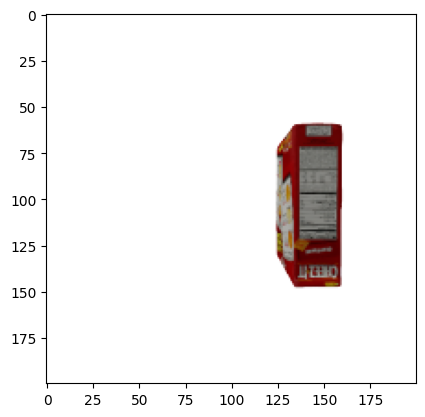

In [146]:
plt.imshow(im_target)

In [ ]:
a = get_scipy_image(get_se3_pose(new_pose_6d))

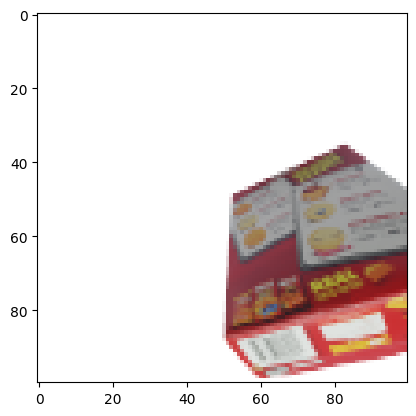

In [34]:
plt.imshow(target_image_np)

In [75]:
target_pose[:3,-1] *1.25/6

tensor([-0.0690,  0.7527, -0.0617])

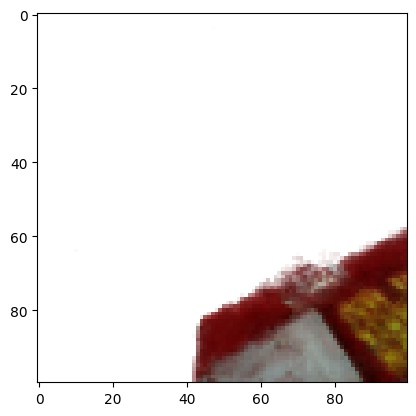

In [72]:
camera = gen_camera(pose, extra_args['focal'], W, H, z_far)
plt.imshow(get_image(camera))